In [32]:
import os
from haystack import Document
from haystack import Pipeline
from matplotlib import pyplot as plt
from haystack.document_stores import InMemoryDocumentStore
from haystack.nodes.retriever.multimodal import MultiModalRetriever

### sentence-transformers/clip-ViT-B-32 
        - This is the Image & Text model CLIP, which maps text and images to a shared vector space. 
          For applications of the models, have a look in our documentation SBERT.net - Image Search

In [33]:
class MultimodalSearch:
    def __init__(
                self,
                doc_dir = "fashon-db"
                ):
        self.document_store = InMemoryDocumentStore(embedding_dim=512) # store 512 dim image embeddings

        images = [
                Document(content=f"./{doc_dir}/{filename}", content_type="image")
                for filename in os.listdir(f"./{doc_dir}")
                ]

        self.document_store.write_documents(images)

        self.retriever_text_to_image = MultiModalRetriever(
                                                            document_store=self.document_store,
                                                            query_embedding_model="sentence-transformers/clip-ViT-B-32",
                                                            query_type="text",
                                                            document_embedding_models={"image": "sentence-transformers/clip-ViT-B-32"},
                                                            )

        # Turn images into embeddings and store them in the DocumentStore
        self.document_store.update_embeddings(retriever=self.retriever_text_to_image)

        self.pipeline = Pipeline()
        self.pipeline.add_node(component=self.retriever_text_to_image, name="retriever_text_to_image", inputs=["Query"])

    def search(self, query, top_k=3):
        results = self.pipeline.run(query=query, params={"retriever_text_to_image": {"top_k": top_k}})
        return sorted(results["documents"], key=lambda d: d.score, reverse=True)
    
    def search_and_show(self, query, top_k=3):
        results = self.search(query, top_k)
        image_paths = [result.content for result in results if result.score > 0.5]
        
        if len(image_paths) == 0:
            print("No results found")
            return
        
        fig = plt.figure(figsize=(15, 15))
        columns = len(image_paths)
        rows = 1
        for i in range(1, columns*rows +1):
            img = plt.imread(image_paths[i-1])
            fig.add_subplot(rows, columns, i)
            plt.imshow(img)
        plt.show()
        

In [34]:
fashion_search = MultimodalSearch()

Documents Processed: 10000 docs [00:00, 11550.80 docs/s]      


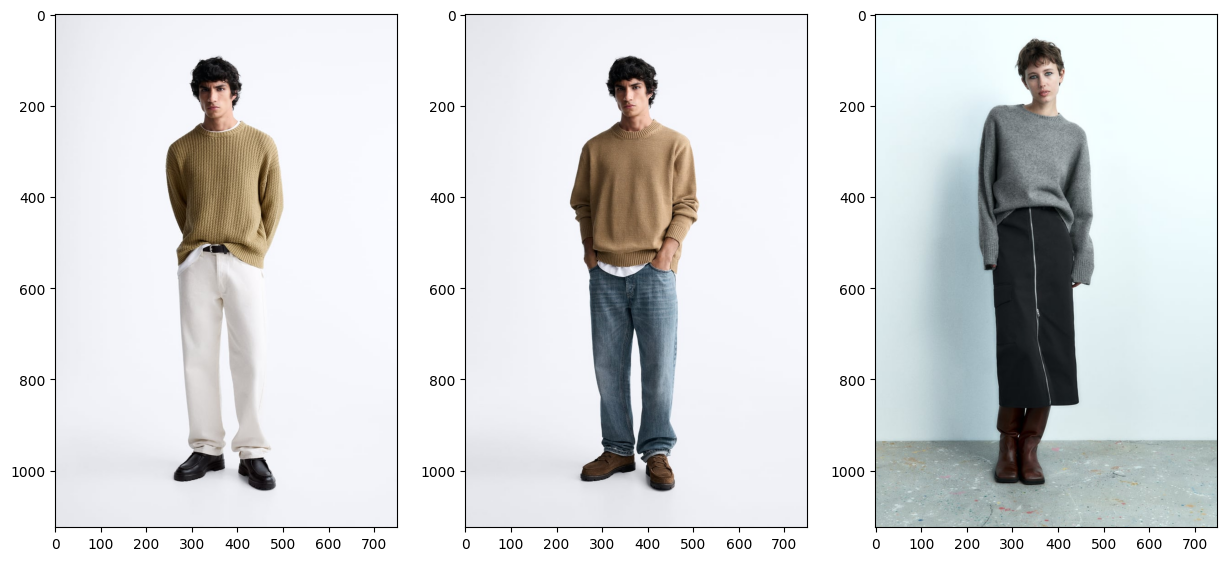

In [35]:
fashion_search.search_and_show("cable knit sweater")